# Datos en Argentina (fuente: informes diarios del ministerio de salud)

En lo siguiente, el día 1 corresponde al 22.01.2020, el día 11 
al 01.02.2020, el día 39 al 01.03.2020, el día 62 al 01.04.2020 
y el día 101 al 01.05.2020


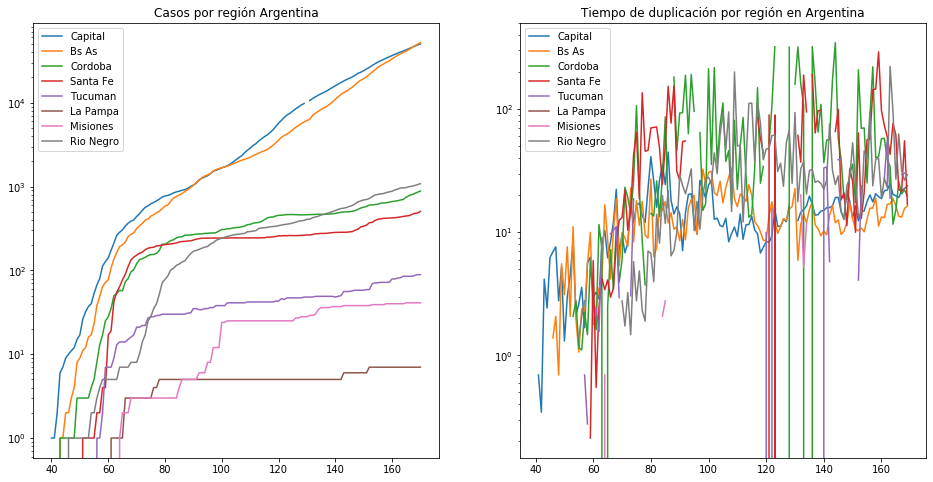

In [1]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas

import warnings
warnings.filterwarnings('ignore')

datosar = pandas.read_csv("../datos/casosar.csv")

fig, axs = plt.subplots(1,2,figsize=(16,8))
ax = axs[0]
for region in ("Capital","Bs As", "Cordoba","Santa Fe","Tucuman", "La Pampa","Misiones","Rio Negro"):
    infectados = datosar[region].to_numpy()
    nuevos = infectados[1:]-infectados[:-1] 
    dias=np.array(range(len(infectados)))+40
    ax.plot(dias,infectados,label=region)

ax.set_title("Casos por región Argentina")
ax.set_yscale("log")
ax.legend()

ax= axs[1]

for region in ("Capital","Bs As", "Cordoba","Santa Fe","Tucuman", "La Pampa","Misiones","Rio Negro"):
    infectados = datosar[region].to_numpy()
    nuevos = infectados[1:]-infectados[:-1] 
    dias=np.array(range(len(nuevos)))+40
    ax.plot(dias,np.log(2)/(nuevos/infectados[:-1]),label=region)

ax.set_title("Tiempo de duplicación por región en Argentina")
ax.set_yscale("log")
ax.legend()



# Levantar Datos a nivel mundial (Fuente: John Hopkings University)

In [2]:
from IPython.display import HTML
import pandas
import json
import numpy as np


data_source="https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename="
data_infected_by_region =   pandas.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv")
data_recovered_by_region =  pandas.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv")
data_deaths_by_region =     pandas.read_csv("https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv")

populations = pandas.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")
populations[populations["Country Name"]=="United States"]
populations=populations.append({"Country Name":"US","Country Code":"USA", "Year":2020,"Value":323127513.},ignore_index=True )
populations=populations.append({"Country Name":"Korea, South","Country Code":"SKorea", "Year":2020,"Value":51606633},ignore_index=True )


import matplotlib.pyplot as plt

countries={"New Zealand","Russia","Kenya","Congo (Kinshasa)","Egypt","Madagascar","South Africa","Ethiopia","Australia","India","Korea, South","Finland","Norway","Argentina","Uruguay","Chile","Brazil","Bolivia","Paraguay","China","Spain","Italy","United Kingdom","US","Sweden"}

nodes = {}

for country in countries:
    data_infected_country = data_infected_by_region[data_infected_by_region["Country/Region"]==country]
    regions = data_infected_country.filter(regex="Province/State")
    regions = regions.to_numpy()[:,0]
    #print("country:",country)
    data_infected_country = data_infected_by_region[data_infected_by_region["Country/Region"]==country]
    data_deaths_country    = data_deaths_by_region[data_deaths_by_region["Country/Region"]==country]
    data_recovered_country = data_recovered_by_region[data_recovered_by_region["Country/Region"]==country]
    for region in regions:
        key = country
        if region is not np.nan:            
            population = np.nan
            key = key + "-" 
            key = key + str(region)
            #data = data_deaths_by_region[data_deaths_by_region["Province/State"]==region]
            data_infected = data_infected_country[data_infected_country["Province/State"]==region]
            data_deaths = data_deaths_country[data_deaths_country["Province/State"]==region]
            data_recovered = data_recovered_country[data_recovered_country["Province/State"]==region]
        else:            
            try:
                population = populations[populations["Country Name"]==country].sort_values("Year").filter(["Value"]).iloc[[-1]].to_numpy()[0,0]
            except:
                population = -1
            data_infected = data_infected_country[data_infected_country["Province/State"].isnull()]
            data_deaths = data_deaths_country[data_deaths_country["Province/State"].isnull()]
            data_recovered =  data_recovered_country[data_recovered_country["Province/State"].isnull()]

        coords =  np.array([data_infected.Long.to_numpy()[0],
                                            data_infected.Lat.to_numpy()[0]])
        data_confirmed = np.array(data_infected.to_numpy()[0,4:], dtype=float)
        data_deaths = np.array(data_deaths.to_numpy()[0,4:], dtype=float)
        data_recovered = np.array(data_recovered.to_numpy()[0,4:], dtype=float)
        data_infected = data_confirmed - data_recovered - data_deaths
        
        
        # Curvas de nuevos recuperados e infectados diarios
        newrecovered = data_recovered[1:]-data_recovered[:-1]  + data_deaths[1:]-data_deaths[:-1]
        newinfecteds = data_confirmed[1:]-data_confirmed[:-1]
        # Para calcular el tiempo de recuperación, asumo que la curva de nuevos infectados y
        # de recuperados tienen la misma distribución, ya que en el modelo T son la misma cantidad
        # desplazada en el tiempo en un plazo igual al tiempo de recuperación.
        # Luego, el tiempo de recuperación puedo estimarlo como el valor medio de $t$
        # pesado con la curva de recuperados, menos el valor medio pesado con la curva de nuevos 
        # infectados.
        days=np.array(range(len(newrecovered)))
        tinc = np.dot(newrecovered,days)/np.sum(newrecovered)-np.dot(newinfecteds,days)/np.sum(newinfecteds)
        tinc = int(round(tinc))
        if tinc < 3:
            tinc = 12
        
        history = np.array([np.array(range(len(data_infected))),data_infected]).transpose()
        peak = sorted(history,key=lambda x:-x[1])[0]
        tmax = peak[0]
        history = history[history[:,1]!=0]
        initial_day = int(history[0][0])
        last_day = int(history[-1][0])
        
        newinfecteds = newinfecteds[initial_day+7:last_day]
        
        data_infected_exp = 1.+newinfecteds/data_infected[initial_day+7:last_day]
        data_infected_exp = data_infected_exp[data_infected_exp is not np.nan][0]
        data_infected_exp = data_infected_exp[data_infected_exp !=np.inf][0]
        infection_rate = np.average(data_infected_exp) 
        if infection_rate == np.inf:
            print(data_infected_exp)
            infection_rate = np.nan
        else:
            err_infection_rate = np.sqrt(np.average(data_infected_exp**2)/infection_rate**2-1)
            if err_infection_rate > .05:
                pass #print("Warning: for ",key," ",infection_rate," +/-",100*err_infection_rate, "%. Probably there was a change of exponent")
                #print(data_infected_exp)
                #plt.plot(data_infected_exp,label=key)
                #plt.legend()
                #plt.show()


        nodes[key]={"coordinates":coords,
                    "population": population,
                    "initial_infected":data_infected[initial_day],
                    "initial_day" : initial_day,
                    "aexp":infection_rate,
                    "err_aexp": err_infection_rate,
                    "initial_immunized":0,
                    "peak": peak,
                    "tinc" : tinc,
                    "curve_confirmed": data_confirmed,
                    "curve_recovered": data_recovered,                                        
                    "curve_deaths": data_deaths,                                        
                    }



        
    
nodes["China-Guangdong"]["population"]=104303132
nodes["China-Shandong"]["population"]=95793065
nodes["China-Henan"]["population"]=94023567
nodes["China-Sichuan"]["population"]=80418200
nodes["China-Jiangsu"]["population"]=78659903
nodes["China-Hebei"]["population"]=71854202
nodes["China-Hunan"]["population"]=65683722
nodes["China-Anhui"]["population"]=59500510
nodes["China-Hubei"]["population"]=57237740
nodes["China-Hubei"]["population"]=57237740
nodes["China-Zhejiang"]["population"]=54426891
nodes["China-Hong Kong"]["population"]=7392000
nodes["China-Beijing"]["population"]=21540000
nodes["China-Fujian"]["population"]=28560000
nodes["China-Gansu"]["population"]=28560000


nodes["China-Chongqing"]["population"] = 30480000
nodes["China-Guangxi"]["population"] = 48380000
nodes["China-Guizhou"]["population"] = 34750000
nodes["China-Hainan"]["population"] = 9258000
nodes["China-Heilongjiang"]["population"] = 38310000
nodes["China-Inner Mongolia"]["population"] = 24710000
nodes["China-Jiangxi"]["population"] = 45200000
nodes["China-Jilin"]["population"] = 27460000
nodes["China-Liaoning"]["population"] = 43900000
nodes["China-Macau"]["population"] = 622567
nodes["China-Ningxia"]["population"] = 6300000
nodes["China-Qinghai"]["population"] = 5627000
nodes["China-Shaanxi"]["population"] = 37330000
nodes["China-Shanghai"]["population"] = 24280000
nodes["China-Shanxi"]["population"] = 36500000
nodes["China-Tianjin"]["population"] = 11558000
nodes["China-Tibet"]["population"] = 3180000
nodes["China-Xinjiang"]["population"] = 21810000
nodes["China-Yunnan"]["population"] = 45970000




# Salvar los datos a un array de json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

with open("../Datos/data.json","w") as f:
    f.write(json.dumps(nodes, sort_keys=True,cls=NumpyEncoder))



## Curvas de contagio y ajustes

## Evolución del número de activos

In [9]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import pandas as pd


region = widgets.Dropdown(options=[key for key in nodes],
    description='Region:',
    ensure_option=True,
    disabled=False)

startday =widgets.IntSlider(0,0,200,
    description='ajustar desde el día',
    ensure_option=True,
    disabled=False)

endday =widgets.IntSlider(200,0,200,
    description='ajustar hasta el día',
    ensure_option=True,
    disabled=False)

tipoescala = widgets.Dropdown(options=['log','linear'],
    description='tipo escala:',
    ensure_option=True,
    disabled=False)




def mostrar_curva(region,start,end,tipoescala):
    data_confirmed = nodes[region]["curve_confirmed"]
    data_death = nodes[region]["curve_deaths"]
    data_recovered = nodes[region]["curve_recovered"]
    activos = data_confirmed-data_death-data_recovered
    ts = np.array(range(len(activos)))
    values = activos[start:end]    
    ts = ts[start:end]
    ts = ts[(~np.isnan(values))]
    values = values[(~np.isnan(values))]
    ts = ts[values>0]
    values = values[values>0]
    lnvalues = np.log(values)        
    plt.scatter(ts,values,label=region)
    try:
        fit = np.polyfit(ts-ts[0],lnvalues, 1, cov=False)
        print("t duplicación:", np.log(2.)/fit[0], " ordenada al origen:",np.exp(fit[1]))
        plt.plot(ts,np.exp(fit[0]*(ts-ts[0])+fit[1]),label=region)
    except:
        pass
    plt.yscale(tipoescala)
    plt.title("Número de casos activos en " + region)
    plt.show()
    
interact=widgets.interact(mostrar_curva,region=region,start=startday,end=endday,tipoescala=tipoescala)


interactive(children=(Dropdown(description='Region:', options=('Madagascar', 'Finland', 'Bolivia', 'Congo (Kin…

## Evolución de la tasa de infección y tiempo característico.

La tasa de infección es, en el modelo SIR, el factor que relaciona el incremento diario del número de casos activos con el producto del número actual de casos activos y la fracción de la población susceptible. En el modelo SIR convencional, esta cantidad es una "constante" que depende tanto a la "contagiosidad" (cuan probable es que la infección salte de un individuo a otro que se encuentran en condiciones normales) como a las políticas sanitarias. Una aislación completa de todos los individuos (sanos e infectados) debería llevar a esta cantidad a cero, pero también lo puede hacer la evolución natural del virus (degradación genómica).   

Para analizar la hipótesis de que la degradación genómica controla la dinámica de esta variable, vamos a graficar el tiempo característico asociado, y lo vamos a ajustar con una ley exponencial. Si el tiempo característico de relajación  de la tasa de infección se mantiene invariante en muchos contextos distintos, podemos asumir que ese tiempo característico está controlado más fuertemente por la degradación genómica que por las políticas y hábitos de las poblaciones.


In [36]:


def mostrar_curva2(region,start,end,tipoescala):
    data_confirmed = nodes[region]["curve_confirmed"]
    data_death = nodes[region]["curve_deaths"]
    data_recovered = nodes[region]["curve_recovered"]
    activos = data_confirmed-data_death-data_recovered
    newrecovered = data_recovered[1:]-data_recovered[:-1] # +data_deaths[1:]-data_deaths[:-1]
    newdeaths = data_deaths[1:]-data_deaths[:-1] # +data_deaths[1:]-data_deaths[:-1]
    newinfected = data_confirmed[1:]-data_confirmed[:-1]
    newactivos = activos[1:]-activos[:-1]
    ts = np.array(range(len(newinfected)))
    values = newinfected/activos[1:]
    ts = ts[start:end]
    values = values[start:end]    
    ts = ts[(~np.isnan(values))]
    values = values[(~np.isnan(values))]
    ts = ts[values>0]
    values = np.log(2)/values[values>0]
    lnvalues = np.log(values)        
    plt.scatter(ts, values, label=region)
    try:
        fit = np.polyfit(ts-ts[0],lnvalues, 1, cov=False)
        print("Tiempo característico :", fit[0], " ordenada al origen:",np.exp(fit[1]))
        plt.plot(ts,np.exp(fit[0]*(ts-ts[0])+fit[1]),label=region)
    except:
        pass
    plt.yscale(tipoescala)
    plt.ylabel("$T_{duplicaci\'on}$")
    plt.xlabel("Fecha")
    #plt.plot(np.log(newrecovered),label="nuevos recuperados")
    #plt.plot(np.log(newdeaths),label="nuevos muertos")
    plt.title("Inversa de la Tasa de infección en " + region)
    # plt.legend()
    
region2 = widgets.Dropdown(options=[key for key in nodes],
    description='Region:',
    ensure_option=True,
    disabled=False)

startday2 =widgets.IntSlider(0,0,200,
    description='ajustar desde el día',
    ensure_option=True,
    disabled=False)

endday2 =widgets.IntSlider(200,0,200,
    description='ajustar hasta el día',
    ensure_option=True,
    disabled=False)

tipoescala2 = widgets.Dropdown(options=['log','linear'],
    description='tipo escala:',
    ensure_option=True,
    disabled=False)

interact=widgets.interact(mostrar_curva2,region=region2,start=startday2,end=endday2,tipoescala=tipoescala2)


interactive(children=(Dropdown(description='Region:', options=('Madagascar', 'Finland', 'Bolivia', 'Congo (Kin…